# Module 05 Project Overview

The purpose of this project is to examine the relationship between hyperglycemic tests and hospital readmittance rates of patients with diabetes as a diagnosis. The model will attempt to predict which patients are likely to be readmitted for complications and categorized as being hospitalized within a month, more than a month from most recent discharge, and never. This model and similar models can change when testing is administered, possibly resulting in earlier diagnosis and preventative measures to be taken during the initial treatment period to avoid readmittance, lowering healthcare costs for both patient and hospital. 

This machine learning project is a supervised, multi-class classification problem.

You'll find the accompanying biomedical research paper with label descriptions and further information <a href="http://dx.doi.org/10.1155/2014/781670">here.</a>

# FEATURE IMPORTANCE

In [1]:
# from eli5.sklearn import PermutationImportance

# permumtation_impor = PermutationImportance(random_forest, random_state=2019).fit(X_test, y_test)
# eli5.show_weights(permumtation_impor, feature_names = X_test.columns.tolist())

In [2]:
# standard imports
import pandas as pd
import numpy as np
import pandas_profiling

import warnings
warnings.filterwarnings("ignore")

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns

# modeling
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report
from xgboost import XGBClassifier

# resampling
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, RandomOverSampler

Using TensorFlow backend.


In [3]:
raw_df = pd.read_csv("diabetes_data.csv")
df = pd.read_csv("diabetes_data.csv")

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
len(df)

101766

In [6]:
#df.profile_report()

# Preprocessing

In [7]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [8]:
df.drop(['weight','payer_code', 'citoglipton','examide'], inplace=True, axis=1) #Dropping weight since too few rows have actual values
# Payer Code unnecessary for classification task
#Rejected citoglipton and examide - all "no"

Because the medical specialty of the service provider could have influence on whether the H1bAlc test was performed, missing values will be replace with 'Unknown'.

In [9]:
df['medical_specialty'].replace(to_replace='?', value='Unknown', inplace=True)

In [10]:
df.race.value_counts(normalize=True)

Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: race, dtype: float64

The following code replaces missing values in the race column with a random choice aligned with the probabilities of all other race options.

In [11]:
df['race'] = df['race'].apply(lambda x: np.random.choice(['Caucasian', 'AfricanAmerican','Hispanic', 'Other', 'Asian'], p=[0.76, 0.19, 0.02, 0.02, 0.01]) if x == '?' else x)

In [12]:
df.race.value_counts(normalize=True) #Confirming appropriate distribution

Caucasian          0.764725
AfricanAmerican    0.193080
Hispanic           0.020508
Other              0.015152
Asian              0.006535
Name: race, dtype: float64

In [13]:
df.gender.value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [14]:
df = df[df.gender != 'Unknown/Invalid'] #dropping the three unknown gender rows

Due to my lack of medical knowledge, the following function will take in a column of ICD9 codes and replace them with the verbal diagnosis. This will help my understanding of the data. 

In [15]:
def diagnose(x):
    if (x >= 390) and (x <= 459) or (x == 785):
        return 'circulatory'
    
    elif (x >= 460) and (x <= 519) or (x == 786):
        return'respiratory'
    
    elif (x >= 520) and (x <= 579) or (x == 787):
        return 'digestive'
    
    elif (x >= 250) and (x <= 251):
        return 'diabetes'
    
    elif (x >= 800) and (x <= 999):
        return 'injury_poisoning'
    
    elif (x >= 710) and (x <= 739): 
        return 'musculoskeletal'
    
    elif (x >= 580) and (x <= 629) or (x == 788): 
        return 'genitourinary'
    
    elif (x >= 140) and (x <= 239): 
         return'neoplasms'
    
    elif (x >= 240) and (x <= 279): 
         return'endocrine_nutrition_metabolic'
    
    elif (x >= 680) and (x <= 709) or (x == 782): 
         return'skin_disease'
    
    elif (x >= 1) and (x <= 139): 
         return'infection_parasites'
    
    elif (x >= 290) and (x <= 319): 
        return 'mental'
    
    elif (x >= 0) and (x <1) or (x == 786): 
        return 'external_injury'
    
    elif (x >= 280) and (x <= 289):
        return 'blood'
    
    elif (x >= 320) and (x <= 359): 
        return 'nervous'
    
    elif (x >= 630) and (x <= 679):
        return 'pregnancy_childbirth'
    
    elif (x >= 360) and (x <= 389): 
        return 'sensory'
    
    elif (x >= 740) and (x <= 759):
        return 'congenital'
    
    elif (x >= 789) and (x <= 799) or (x == 780) or (x == 781) or (x == 784) or (x == 783):
        return 'other'
    else:
        return x

In [16]:
for col in ['diag_1', 'diag_2', 'diag_3']: 
    df[col] = [x.replace('V', "0.") for x in df[col]]
    df[col] = [x.replace('E', '0.') for x in df[col]]
    df[col] = [x.replace('?', '0') for x in df[col]]
    df[col] = df[col].astype(float)

In [17]:
df.diag_1 = df.diag_1.apply(diagnose)
df.diag_2 = df.diag_2.apply(diagnose)
df.diag_3 = df.diag_3.apply(diagnose)

In [18]:
for col in ['diag_1', 'diag_2', 'diag_3']:
    print(col, df[col].unique(), '\n\n')

diag_1 ['diabetes' 'endocrine_nutrition_metabolic' 'pregnancy_childbirth'
 'infection_parasites' 'neoplasms' 'circulatory' 'respiratory'
 'injury_poisoning' 'skin_disease' 'musculoskeletal' 'digestive'
 'external_injury' 'genitourinary' 'mental' 'other' 'nervous' 'blood'
 'sensory' 'congenital'] 


diag_2 ['external_injury' 'diabetes' 'neoplasms' 'circulatory' 'respiratory'
 'blood' 'injury_poisoning' 'musculoskeletal' 'genitourinary'
 'infection_parasites' 'endocrine_nutrition_metabolic' 'digestive'
 'skin_disease' 'nervous' 'other' 'mental' 'pregnancy_childbirth'
 'congenital' 'sensory'] 


diag_3 ['external_injury' 'endocrine_nutrition_metabolic' 'circulatory'
 'diabetes' 'infection_parasites' 'respiratory' 'injury_poisoning'
 'neoplasms' 'genitourinary' 'musculoskeletal' 'other' 'digestive'
 'skin_disease' 'mental' 'congenital' 'nervous' 'sensory'
 'pregnancy_childbirth' 'blood'] 




Keeping in line with the research paper, for patients who have had multiple encounters, each encounter past the first has been removed as they cannot be deemed statistically independent. 

In [19]:
df = df.drop_duplicates(subset=['patient_nbr'], keep='first')

# Exploratory Data Analysis

In [20]:
target = df.readmitted
features = df.drop('readmitted', axis=1)

In [21]:
#df.profile_report()

Since the problem we're trying to solve is classifying and predicting patients that received the H1BA1c hyperglycemia test and the likelihood that they will be readmitted for complications, we'll take a look at readmittance rates for those who have received and have not received the test. 

In [22]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [23]:
tested = df.loc[df.A1Cresult != 'None']
not_tested = df.loc[df.A1Cresult == 'None']

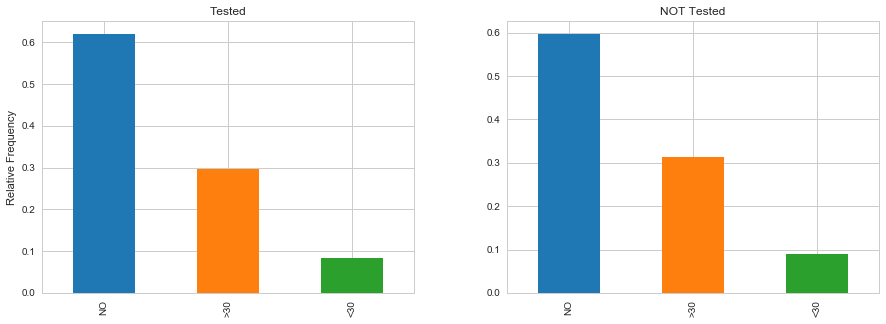

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
tested.readmitted.value_counts(normalize=True).plot(kind='bar', ax=ax1)
not_tested.readmitted.value_counts(normalize=True).plot(kind='bar', ax=ax2)
ax1.set_ylabel('Relative Frequency')
plt.subplots_adjust(wspace=.25)
ax1.set_title("Tested")
ax2.set_title("NOT Tested")

plt.show()

As you can see in the plots above, whether or not patients were tested for hyperglycemia, 40% of patients were readmitted. You can also observe the class disparity which will need to be remedied before modeling can begin.

Female    38025
Male      33490
Name: gender, dtype: int64


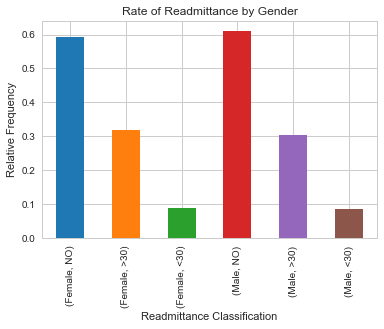

In [25]:
df.groupby(df.gender).readmitted.value_counts(normalize=True).plot(kind='bar', stacked=True)
plt.title('Rate of Readmittance by Gender')
plt.xlabel('Readmittance Classification')
plt.ylabel('Relative Frequency');
print(df.gender.value_counts())

More African American and Caucasian women are readmitted than men, however  , and both men and women are more often not readmitted, and lease likely to be readmitted within the thirty days following discharge. 

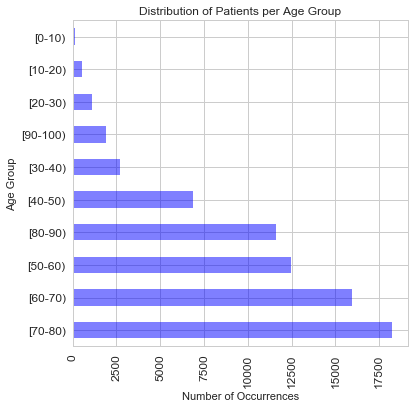

In [26]:
fig = plt.figure(figsize=(6,6))

df.age.value_counts().plot(kind='barh', color='blue', alpha=.5)
plt.title('Distribution of Patients per Age Group')
plt.ylabel('Age Group')
plt.xticks(rotation='vertical', size='large')
plt.yticks(size='large')
plt.xlabel('Number of Occurrences');

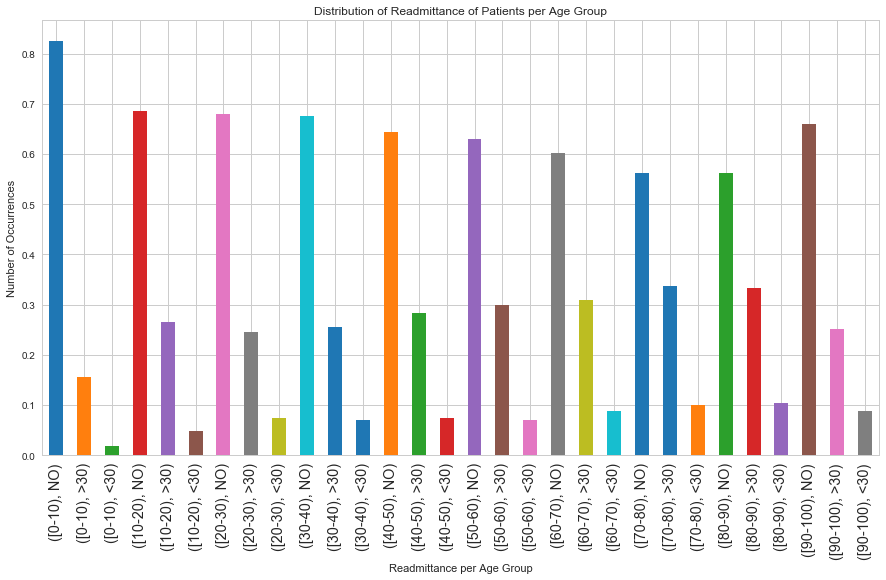

In [27]:
fig = plt.figure(figsize=(15,8))
age_df = df.groupby(df.age)

age_df.readmitted.value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Readmittance of Patients per Age Group')
plt.xlabel('Readmittance per Age Group')
plt.xticks(rotation='vertical', size='x-large')
plt.ylabel('Number of Occurrences');

If you look closely, there is a general downward trend as patients increase in age for those who are not readmitted, while the rate of readmittance increases with age. There is another increase for patients who are 90-100 years old, though that may be due to the patient expiring or moving to hospice care.  

In [28]:
diabetes2 = tested.loc[tested['diag_2']=='diabetes'] 
diabetes2.loc[diabetes2['A1Cresult'] != 'None'].readmitted.value_counts(normalize=True)*100

NO     63.397129
>30    28.803828
<30     7.799043
Name: readmitted, dtype: float64

In [29]:
tested.groupby('diag_1').A1Cresult.value_counts(normalize=True)*100

diag_1                         A1Cresult
blood                          Norm         52.857143
                               >8           31.428571
                               >7           15.714286
circulatory                    >8           46.636012
                               Norm         29.235237
                               >7           24.128751
congenital                     >8           57.142857
                               >7           28.571429
                               Norm         14.285714
diabetes                       >8           73.493976
                               Norm         16.530120
                               >7            9.975904
digestive                      >8           42.216981
                               Norm         32.900943
                               >7           24.882075
endocrine_nutrition_metabolic  >8           43.333333
                               Norm         32.500000
                               >7        

# Machine Learning Modeling

In [30]:
df.readmitted.value_counts(normalize=True)

NO     0.601021
>30    0.310984
<30    0.087996
Name: readmitted, dtype: float64

In [31]:
features.drop(['encounter_id','patient_nbr'], inplace=True, axis=1) #eliminating irrelevant ordinal data
features.columns = features.columns.str.replace("[", "_") 

In [32]:
features = features.astype('category', inplace=True)
features = pd.get_dummies(features)
len(features.columns)

566

## Resampling

In order for our models to work properly, we'll need to address the class imbalance of our target variable. I'll try three different resampling methods after first separating into the training and testing sets, setting a baseline model, and identifying the performance metric.

In [33]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=.2)

In [34]:
log = LogisticRegression().fit(x_train, y_train)
 
# Predict on training set
preds = log.predict(x_test)

# Checking accuracy
print('Accuracy Score: ', accuracy_score(y_test, preds),'\n\n')
print('Averaged Recall Score: ', recall_score(y_test, preds, average='weighted'), '\n\n')
    
log_report = classification_report(y_test, preds)
print(classification_report(y_test, preds))
# Checking unique values
predictions = pd.DataFrame(preds)
print(f'Distribution of Classifications (%)')
predictions[0].value_counts(normalize=True) *100
  

Accuracy Score:  0.6151856253932741 


Averaged Recall Score:  0.6151856253932741 


              precision    recall  f1-score   support

         <30       0.38      0.01      0.02      1241
         >30       0.49      0.19      0.28      4479
          NO       0.63      0.92      0.75      8583

    accuracy                           0.62     14303
   macro avg       0.50      0.38      0.35     14303
weighted avg       0.57      0.62      0.54     14303

Distribution of Classifications (%)


NO     87.331329
>30    12.389009
<30     0.279662
Name: 0, dtype: float64

Not the best scores. Because of the class imbalance, the model is favoring 'NO' but our goal is to prevent patients from being readmitted. 

Our goal for the model will be to reduce false negatives by optimizing for recall. Let's compare Random Forests classification method against logistic regression.

In [35]:
rf = RandomForestClassifier().fit(x_train, y_train)
 
# Predict on training set
preds = rf.predict(x_test)

# Checking accuracy
print('Accuracy Score: ', accuracy_score(y_test, preds),'\n\n')
print('Averaged Recall Score: ', recall_score(y_test, preds, average='weighted'), '\n\n')
    
print(classification_report(y_test, preds))
# Checking unique values
predictions = pd.DataFrame(preds)
print(f'Distribution of Classifications (%)')
predictions[0].value_counts(normalize=True) *100

Accuracy Score:  0.5758931692651891 


Averaged Recall Score:  0.5758931692651891 


              precision    recall  f1-score   support

         <30       0.18      0.02      0.04      1241
         >30       0.41      0.31      0.35      4479
          NO       0.64      0.79      0.71      8583

    accuracy                           0.58     14303
   macro avg       0.41      0.38      0.37     14303
weighted avg       0.52      0.58      0.54     14303

Distribution of Classifications (%)


NO     74.816472
>30    24.148780
<30     1.034748
Name: 0, dtype: float64

The distribution of classes improved, but recall and f1 scores decreased. We'll move forward with our resampling methods and compare the results of the logistical regression model. 

### Oversampling the Minority

In [36]:
# Returning to one dataframe
train = pd.concat([x_train, y_train], axis=1)

# Separating classes
not_readmitted = train[train.readmitted == 'NO']
less_than = train[train.readmitted == '<30']
more_than = train[train.readmitted == '>30']

# Resampling minority classes
less_oversample = resample(less_than, 
                              replace=True, 
                              n_samples=len(not_readmitted),
                              random_state=42)
more_oversample =resample(more_than, 
                              replace=True, 
                              n_samples=len(not_readmitted),
                              random_state=42)

# Returning to new training set
oversample_train = pd.concat([not_readmitted, less_oversample, more_oversample])

oversample_train.readmitted.value_counts(normalize=True)

<30    0.333333
>30    0.333333
NO     0.333333
Name: readmitted, dtype: float64

Now that we've upsampled our minority classes and each class is equal in size, we can refit the base model on the balanced data. 

In [37]:
oversample_x_train = oversample_train.drop('readmitted', axis=1)
oversample_y_train = oversample_train.readmitted

oversample_log = LogisticRegression().fit(oversample_x_train, oversample_y_train)
 
# Predict on training set
oversample_preds = oversample_log.predict(x_test)

# Checking accuracy
print('Accuracy Score: ', accuracy_score(y_test, oversample_preds),'\n\n')
print('Averaged Recall Score: ', recall_score(y_test, oversample_preds, average='weighted'), '\n\n')
    
print(classification_report(y_test, oversample_preds))
# Checking unique values
predictions = pd.DataFrame(oversample_preds)
print(f'Distribution of Classifications (%)')
predictions[0].value_counts(normalize=True) *100

Accuracy Score:  0.47829126756624485 


Averaged Recall Score:  0.47829126756624485 


              precision    recall  f1-score   support

         <30       0.14      0.41      0.21      1241
         >30       0.41      0.42      0.42      4479
          NO       0.73      0.52      0.60      8583

    accuracy                           0.48     14303
   macro avg       0.43      0.45      0.41     14303
weighted avg       0.58      0.48      0.51     14303

Distribution of Classifications (%)


NO     42.662379
>30    32.084178
<30    25.253443
Name: 0, dtype: float64

Accuracy decreased, but the f1 scores of the readmitted classes did improve slightly. However, our goal is to reduce the number of false negatives, which can be reached by a higher recall. Next, we'll look at downsampling. 

### Undersampling the Majority

In [38]:
readmitted = train[train.readmitted != "NO"]
undersample = resample(not_readmitted, 
                              replace=True, 
                              n_samples=len(readmitted),
                              random_state=42)


# Returning to new training set
undersample_train = pd.concat([readmitted, undersample])

undersample_train.readmitted.value_counts(normalize=True)

NO     0.500000
>30    0.389274
<30    0.110726
Name: readmitted, dtype: float64

In [39]:
undersample_x_train = undersample_train.drop('readmitted', axis=1)
undersample_y_train = undersample_train.readmitted

undersample_log = LogisticRegression().fit(undersample_x_train, undersample_y_train)
 
# Predict on training set
undersample_preds = undersample_log.predict(x_test)

# Checking accuracy
print('Accuracy Score: ', accuracy_score(y_test, undersample_preds),'\n\n')
print('Averaged Recall Score: ', recall_score(y_test, undersample_preds, average='weighted'), '\n\n')
    
print(classification_report(y_test, undersample_preds))
# Checking unique values
predictions = pd.DataFrame(undersample_preds)
print(f'Distribution of Classifications (%)')
predictions[0].value_counts(normalize=True) *100

Accuracy Score:  0.5949800741103265 


Averaged Recall Score:  0.5949800741103265 


              precision    recall  f1-score   support

         <30       0.33      0.03      0.06      1241
         >30       0.44      0.44      0.44      4479
          NO       0.67      0.76      0.71      8583

    accuracy                           0.59     14303
   macro avg       0.48      0.41      0.40     14303
weighted avg       0.57      0.59      0.57     14303

Distribution of Classifications (%)


NO     67.762008
>30    31.440956
<30     0.797036
Name: 0, dtype: float64

In [40]:
print(log_report)

              precision    recall  f1-score   support

         <30       0.38      0.01      0.02      1241
         >30       0.49      0.19      0.28      4479
          NO       0.63      0.92      0.75      8583

    accuracy                           0.62     14303
   macro avg       0.50      0.38      0.35     14303
weighted avg       0.57      0.62      0.54     14303



This model performed slightly better. While recall dropped .02 points for the weighted average, the f1 score did increase and the distribution of the classifications is more similar than oversampling. We'll try one more technique before moving on. 

### SMOTE (Synthetic Minority Oversampling Technique)

SMOTE is a nearest-neighbors algorithm that synthesizes data to supplement the real minority data for an even more robust training dataset.

In [41]:
not_admitted = sum(target=='NO')
less = not_admitted - sum(target == '<30') 
greater = not_admitted - sum(target == '>30')

sampling_dist = {'<30': not_admitted, '>30':not_admitted}
sm = SMOTE(random_state=42, sampling_strategy=sampling_dist)
smote_x_train, smote_y_train = sm.fit_resample(x_train, y_train)

In [42]:
smote_log = LogisticRegression().fit(smote_x_train, smote_y_train)
 
# Predict on training set
smote_preds = smote_log.predict(x_test)

# Checking accuracy
print('Accuracy Score: ', accuracy_score(y_test, smote_preds),'\n\n')
print('Averaged Recall Score: ', recall_score(y_test, smote_preds, average='weighted'), '\n\n')
    
print(classification_report(y_test, smote_preds))
# Checking unique values
predictions = pd.DataFrame(smote_preds)
print(f'Distribution of Classifications (%)')
predictions[0].value_counts(normalize=True) *100

At this point, we'll move forward with the undersampled majority as our training set. 

## Pipelines

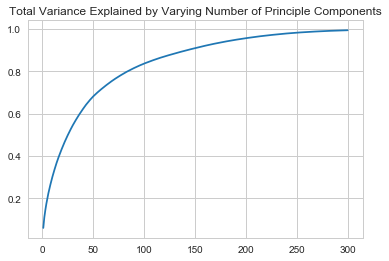

In [92]:
pca = PCA(n_components=300, whiten=True)
X_pca_train = pca.fit_transform(undersample_x_train)

plt.plot(range(1,301), pca.explained_variance_ratio_.cumsum())
plt.title('Total Variance Explained by Varying Number of Principle Components');

In [ ]:
X_pca_test = pca.transform(x_test)
clf = XGBClassifier()
%timeit clf.fit(X_pca_train, undersample_y_train)

In [43]:
tree_pipe = Pipeline([('pca', PCA(n_components=200)),
                ('tree', tree.DecisionTreeClassifier(random_state=42))])

tree_pipe.fit(undersample_x_train, undersample_y_train)

print('Test accuracy: %.3f' % tree_pipe.score(x_test, y_test))
#print('\nModel hyperparameters:\n', pipe.steps[1].get_params())

Test accuracy: 0.432


In [44]:
ada_pipe = Pipeline([('pca', PCA(n_components=200)),
               
                ('ada', AdaBoostClassifier(random_state=42))])

ada_pipe.fit(undersample_x_train, undersample_y_train)

print('Test accuracy: %.3f' % ada_pipe.score(x_test, y_test))

Test accuracy: 0.582


In [45]:
gb_pipe = Pipeline([('pca', PCA(n_components=200)),
               
                ('gb', GradientBoostingClassifier(random_state=42))])

gb_pipe.fit(undersample_x_train, undersample_y_train)

print('Test accuracy: %.3f' % gb_pipe.score(x_test, y_test))

Test accuracy: 0.603


In [47]:
xgb_pipe = Pipeline([('pca', PCA(n_components=250)),
               
                ('xgb', XGBClassifier(random_state=42))])

#xgb_pipe.fit(undersample_x_train, undersample_y_train)

print('Train accuracy: %.3f' % xgb_pipe.score(undersample_x_train, undersample_y_train))
print('Test accuracy: %.3f' % xgb_pipe.score(x_test, y_test))

Test accuracy: 0.603


In [49]:
from sklearn.model_selection import GridSearchCV

In [71]:
undersample_x_train.columns = undersample_x_train.columns.str.replace("[", "_")
x_test.columns = x_test.columns.str.replace("[", "_")

In [86]:
param_grid = {
    'xgb__learning_rate': [0.1,0.2],
    'xgb__max_depth': [6],
    'xgb__min_child_weight': [1, 2],
    'xgb__subsample': [0.5, 0.7],
    'xgb__n_estimators': [100],
}

gs_xgb = GridSearchCV(estimator=xgb_pipe,
            param_grid=param_grid,
            scoring='recall_weighted',
            cv=3, verbose=1, n_jobs=-1, return_train_score = True)

# Fit using grid search
grid_xgb = gs_xgb.fit(undersample_x_train, undersample_y_train)

best_parameters = grid_xgb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_xgb.predict(undersample_x_train)
test_preds = grid_xgb.predict(x_test)
training_accuracy = accuracy_score(undersample_y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 